In [1]:
import pandas as pd
import math
from Bio import SeqIO
from scipy import stats
import numpy as np

## Data wrangling

Use tracy program to align and get base call intensities for Sanger reads

In [2]:
from pathlib import Path
import os
import json
import re

class trace():
    """Class which represents individual Sanger sequence trace (ab1 files).
    """

    def __init__(self, ab1_path, expected_conversion, ref, output_dir, insert, adar, rnaseh, sample_id):
        self.ab1_path = Path(ab1_path)
        self.ref = Path(ref)
        self.expected_conversion = expected_conversion
        self.output_dir = Path(output_dir)
        self.insert = insert
        self.adar = adar
        self.rnaseh = rnaseh
        self.sample_id = sample_id
    
    @property
    def basecall_file(self):
        return f'{self.output_dir.joinpath(self.ab1_path.stem)}.tracy.basecalls.tsv'
    
    @property
    def align_file(self):
        return f'{self.output_dir.joinpath(self.ab1_path.stem)}.tracy.align.json'
    

    def _tracy_basecall(self):
        """Use Tracy to generate basecalls from the provided abi file. Since
        we are lazy for now assume that Tracy is globally available.

        After the basecalls are saved to a tsv file read and return the results as
        a pandas dataframe.
        """

        cmd = f"tracy basecall -f tsv -o {str(self.basecall_file)} {str(self.ab1_path)}"
        os.system(cmd)

        return pd.read_csv(self.basecall_file, sep='\t')
    
    def _tracy_align(self, basecalls):
        
        cmd = f'tracy align -l 0 -r 0 -f align -g {str(self.ref)} -o {self.align_file} {str(self.ab1_path)}'
        os.system(cmd)
        
        with open(str(self.align_file)) as handle:
            align_text = handle.read()
        
        # Use regex to pull out alignment text
        
        ref = ''.join(re.findall('Ref\s+\d+\s(.+)', align_text))
        alt = ''.join(re.findall('Alt\s+\d+\s(.+)', align_text))
        
        # To assign basecalls from Tracy basecall file to a reference nucleotide
        # start by assuming everything is a gap. Then if we encounter a gap in the
        # trace (alt) alignment skip one basepair in the reference. Without doing
        # this gaps in the alt alignment would cause the alignment to be off by
        # the total length of gaps compared to the basecalls
        
        # Tracy sort of put all this information together in its json output but the
        # alignments there are not the same as the basecalls within the json file
        # or from the output of basecall program so I am not sure what is going
        # on there so we have to put them together manually
        
        nuc_adds = ['-'] * len(basecalls)

        positions_added = 0

        for r, a in zip(ref, alt):
            if a == '-':
                continue
            else:
                nuc_adds[positions_added] = r
            positions_added += 1
        
        basecalls['ref_nuc'] = nuc_adds
        
        return basecalls
    

    def analyize(self):
        """This method is really the core functionality of the script. The idea being we will use
        the relative signal that is included as part of the Tracy basecalls in order to locate
        bases where editing may have occurred in some population of the molecules present in the
        Sanger sequencing reaction. 
        """

        # Call bases using Tracy
        basecalls = self._tracy_basecall()

        # ab1 files include 10 values per base. Tracy retains those values which is nice but to
        # simplify we will throw out rows that are not assigned to a nucleotide position. The
        # sites that are retained should be the peak crests

        bc_trim = basecalls.loc[~basecalls['basenum'].isna()]

        assert len(bc_trim) > 0
        
        
        bc_trim_ref = self._tracy_align(bc_trim)
        
        
        bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
        bc_trim_ref['sum_signal'] = bc_trim_ref['peakA'] + bc_trim_ref['peakT'] + bc_trim_ref['peakG'] + bc_trim_ref['peakC']        
        bc_trim_ref['ADAR'] = self.adar
        bc_trim_ref['insert'] = self.insert
        bc_trim_ref['rnaseh'] = self.rnaseh
        bc_trim_ref['sample_ID'] = self.sample_id


        return bc_trim_ref

Read ab1 trace files.

In [3]:
reads_dir = Path('../sangerSeq/2-3-23/2023-02-03_827248')

reads = [p for p in reads_dir.iterdir() if p.suffix == '.ab1']

reads

[PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-16_VRI_1__2023-02-04_H04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-6_VRI_1__2023-02-04_B04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-13_VRI_1__2023-02-04_E04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-7_VRI_1__2023-02-04_C04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-8_VRI_1__2023-02-04_D04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-15_VRI_1__2023-02-04_G04.ab1'),
 PosixPath('../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-5_VRI_1__2023-02-04_A04.ab1')]

In [4]:
reads_list = []

for r in reads:
    reads_list.append(
    {
        'ab1_path': str(r),
        'sample_ID': int(r.stem.split('_VRI')[0].split('-')[-1])
    }
    
    )
reads_df = pd.DataFrame(reads_list)
reads_df

,ab1_path,sample_ID
0,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,14
1,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,16
2,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,6
3,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,13
4,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,7
5,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,8
6,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,15
7,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,5


Reads template files.

In [5]:
templates = [p for p in Path('../templates').iterdir() if p.suffix == '.fa']

templates

[PosixPath('../templates/T7_init_VR-26.in.fa'),
 PosixPath('../templates/T7_init_VR-22.in.fa'),
 PosixPath('../templates/T7_init_VR-23.in.fa')]

In [6]:
temps = []

for path in templates:
    temps.append({
        'name': path.stem,
        'path': str(path),
        'insert': int(path.stem.split('VR-')[-1].split('.')[0])
        
    })
template_df = pd.DataFrame(temps)
template_df

,name,path,insert
0,T7_init_VR-26.in,../templates/T7_init_VR-26.in.fa,26
1,T7_init_VR-22.in,../templates/T7_init_VR-22.in.fa,22
2,T7_init_VR-23.in,../templates/T7_init_VR-23.in.fa,23


Read sample assignments into table

In [7]:
samples = pd.read_csv('../sampleTables/ADAR-IVT-samples.csv')

In [8]:
samples.head()

,sample_ID,tube_label,insert,txn,RnaseH,ADAR_species,IVT_date,ADAR_treatment_date,fwd_primer,rev_primer,fwd_primer_seq,rev_primer_seq,pcr_date,num_cycles,anneal_temp,ext_time,pcr_rxn_volume
0,1,23 ADAR2 -RH A-,23,+,-,-,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20
1,2,23 ADAR2 +RH A-,23,+,+,-,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20
2,3,23 ADAR1 -RH A-,23,+,-,-,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20
3,4,23 ADAR1 +RH A-,23,+,+,-,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20
4,5,23 ADAR2 -RH A+,23,+,-,2,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20


In [9]:
samples = samples.merge(template_df, on='insert')

Turn samples dataframe into trace objects. First select samples that were sequenced

In [10]:
exp_1_df = reads_df.merge(samples, on='sample_ID')
exp_1_df.head()

,ab1_path,sample_ID,tube_label,insert,txn,RnaseH,ADAR_species,IVT_date,ADAR_treatment_date,fwd_primer,rev_primer,fwd_primer_seq,rev_primer_seq,pcr_date,num_cycles,anneal_temp,ext_time,pcr_rxn_volume,name,path
0,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,14,22 ADAR2 +RH A+,22,+,+,2,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20,T7_init_VR-22.in,../templates/T7_init_VR-22.in.fa
1,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,16,22 ADAR1 -RH A+,22,+,-,1,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20,T7_init_VR-22.in,../templates/T7_init_VR-22.in.fa
2,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,6,23 ADAR2 +RH A+,23,+,+,2,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20,T7_init_VR-23.in,../templates/T7_init_VR-23.in.fa
3,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,13,22 ADAR2 -RH A+,22,+,-,2,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20,T7_init_VR-22.in,../templates/T7_init_VR-22.in.fa
4,../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT...,7,23 ADAR1 +RH A+,23,+,+,1,1-31-23,1-31-23,PacBioFwdV2-0,PacBioRevV2-0,GGCAAACGCGCCATTCGTGTCGGTTAGAAGCACTAAATCGGAACCC...,ACATTCGCGCACGTGGTGCACGGTTAGAGGCGAACTACTTACTCTA...,2-1-23,30,72,90,20,T7_init_VR-23.in,../templates/T7_init_VR-23.in.fa


In [11]:
Path('sanger-1').mkdir(exist_ok=True)

In [12]:
traces = []

for i, row in exp_1_df.iterrows():
    traces.append(
        trace(
            row.ab1_path, ('T', 'C'), 
            row.path, 
            'sanger-1', 
            row.insert, 
            row.ADAR_species, 
            row.RnaseH,
            row.sample_ID)
    )
traces

In [13]:
trace_data = []

for each_trace in traces:
    trace_data.append(each_trace.analyize())

[2023-Feb-06 13:14:50] tracy basecall -f tsv -o sanger-1/ADAR-IVT-14_VRI_1__2023-02-04_F04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1 
[2023-Feb-06 13:14:50] Done.
[2023-Feb-06 13:14:50] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-22.in.fa -o sanger-1/ADAR-IVT-14_VRI_1__2023-02-04_F04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-14_VRI_1__2023-02-04_F04.ab1 
[2023-Feb-06 13:14:50] Load ab1 file
[2023-Feb-06 13:14:50] Load FASTA reference
[2023-Feb-06 13:14:50] Find reference match
[2023-Feb-06 13:14:50] Alignment
[2023-Feb-06 13:14:50] Output
[2023-Feb-06 13:14:50] Done.


/tmp/ipykernel_21682/3961057931.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = nuc_adds
/tmp/ipykernel_21682/3961057931.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_21682/3961057931.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[2023-Feb-06 13:14:50] tracy basecall -f tsv -o sanger-1/ADAR-IVT-16_VRI_1__2023-02-04_H04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-16_VRI_1__2023-02-04_H04.ab1 
[2023-Feb-06 13:14:50] Done.
[2023-Feb-06 13:14:50] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-22.in.fa -o sanger-1/ADAR-IVT-16_VRI_1__2023-02-04_H04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-16_VRI_1__2023-02-04_H04.ab1 
[2023-Feb-06 13:14:50] Load ab1 file
[2023-Feb-06 13:14:50] Load FASTA reference
[2023-Feb-06 13:14:50] Find reference match
[2023-Feb-06 13:14:50] Alignment
[2023-Feb-06 13:14:50] Output
[2023-Feb-06 13:14:50] Done.


/tmp/ipykernel_21682/3961057931.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = nuc_adds
/tmp/ipykernel_21682/3961057931.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_21682/3961057931.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[2023-Feb-06 13:14:50] tracy basecall -f tsv -o sanger-1/ADAR-IVT-6_VRI_1__2023-02-04_B04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-6_VRI_1__2023-02-04_B04.ab1 
[2023-Feb-06 13:14:50] Done.
[2023-Feb-06 13:14:50] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-23.in.fa -o sanger-1/ADAR-IVT-6_VRI_1__2023-02-04_B04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-6_VRI_1__2023-02-04_B04.ab1 
[2023-Feb-06 13:14:50] Load ab1 file
[2023-Feb-06 13:14:50] Load FASTA reference
[2023-Feb-06 13:14:50] Find reference match
[2023-Feb-06 13:14:50] Alignment
[2023-Feb-06 13:14:50] Output
[2023-Feb-06 13:14:50] Done.
[2023-Feb-06 13:14:50] tracy basecall -f tsv -o sanger-1/ADAR-IVT-13_VRI_1__2023-02-04_E04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-13_VRI_1__2023-02-04_E04.ab1 
[2023-Feb-06 13:14:51] Done.


/tmp/ipykernel_21682/3961057931.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['rnaseh'] = self.rnaseh
/tmp/ipykernel_21682/3961057931.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['sample_ID'] = self.sample_id
/tmp/ipykernel_21682/3961057931.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

[2023-Feb-06 13:14:51] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-22.in.fa -o sanger-1/ADAR-IVT-13_VRI_1__2023-02-04_E04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-13_VRI_1__2023-02-04_E04.ab1 
[2023-Feb-06 13:14:51] Load ab1 file
[2023-Feb-06 13:14:51] Load FASTA reference
[2023-Feb-06 13:14:51] Find reference match
[2023-Feb-06 13:14:51] Alignment
[2023-Feb-06 13:14:51] Output
[2023-Feb-06 13:14:51] Done.
[2023-Feb-06 13:14:51] tracy basecall -f tsv -o sanger-1/ADAR-IVT-7_VRI_1__2023-02-04_C04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-7_VRI_1__2023-02-04_C04.ab1 
[2023-Feb-06 13:14:51] Done.
[2023-Feb-06 13:14:51] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-23.in.fa -o sanger-1/ADAR-IVT-7_VRI_1__2023-02-04_C04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-7_VRI_1__2023-02-04_C04.ab1 
[2023-Feb-06 13:14:51] Load ab1 file
[2023-Feb-06 13:14:51] Load FASTA reference
[2023-Feb-06 13:14:51] Find r

/tmp/ipykernel_21682/3961057931.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basecalls['ref_nuc'] = nuc_adds
/tmp/ipykernel_21682/3961057931.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['conversion_ratio'] = bc_trim_ref['peakC'] / (bc_trim_ref['peakC'] + bc_trim_ref['peakT'])
/tmp/ipykernel_21682/3961057931.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[2023-Feb-06 13:14:51] tracy basecall -f tsv -o sanger-1/ADAR-IVT-15_VRI_1__2023-02-04_G04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-15_VRI_1__2023-02-04_G04.ab1 
[2023-Feb-06 13:14:51] Done.
[2023-Feb-06 13:14:51] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-22.in.fa -o sanger-1/ADAR-IVT-15_VRI_1__2023-02-04_G04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-15_VRI_1__2023-02-04_G04.ab1 
[2023-Feb-06 13:14:51] Load ab1 file
[2023-Feb-06 13:14:51] Load FASTA reference
[2023-Feb-06 13:14:51] Find reference match
[2023-Feb-06 13:14:51] Alignment
[2023-Feb-06 13:14:51] Output
[2023-Feb-06 13:14:51] Done.
[2023-Feb-06 13:14:51] tracy basecall -f tsv -o sanger-1/ADAR-IVT-5_VRI_1__2023-02-04_A04.tracy.basecalls.tsv ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-5_VRI_1__2023-02-04_A04.ab1 


/tmp/ipykernel_21682/3961057931.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['ADAR'] = self.adar
/tmp/ipykernel_21682/3961057931.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['insert'] = self.insert
/tmp/ipykernel_21682/3961057931.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[2023-Feb-06 13:14:51] Done.
[2023-Feb-06 13:14:51] tracy align -l 0 -r 0 -f align -g ../templates/T7_init_VR-23.in.fa -o sanger-1/ADAR-IVT-5_VRI_1__2023-02-04_A04.tracy.align.json ../sangerSeq/2-3-23/2023-02-03_827248/ADAR-IVT-5_VRI_1__2023-02-04_A04.ab1 
[2023-Feb-06 13:14:51] Load ab1 file
[2023-Feb-06 13:14:51] Load FASTA reference
[2023-Feb-06 13:14:51] Find reference match
[2023-Feb-06 13:14:51] Alignment
[2023-Feb-06 13:14:51] Output
[2023-Feb-06 13:14:51] Done.


/tmp/ipykernel_21682/3961057931.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bc_trim_ref['sample_ID'] = self.sample_id


Remove outlier peaks from the dataframe using IQR method. This removes peaks with very low or very high signal from each read

In [14]:
def remove_outlier_peaks(df):
    return df[(np.abs(stats.zscore(df['sum_signal'])) < 3)]


trace_data_prune = []

for each_frame in trace_data:
    trace_data_prune.append(remove_outlier_peaks(each_frame))

len(trace_data_prune)

8

Combine dataframes

In [15]:
all_trace_df = pd.concat(trace_data_prune)

## Analysis

### Determine the C / C + T value at locations that should be T according to the aligned reference sequence

In [16]:
all_trace_df_T = all_trace_df.loc[all_trace_df['ref_nuc'] == 'T']

In [17]:
all_trace_df_T

,pos,peakA,peakC,peakG,peakT,basenum,primary,secondary,consensus,qual,trim,ref_nuc,conversion_ratio,sum_signal,ADAR,insert,rnaseh,sample_ID
2742,2743,49,14,53,845,233.0,T,T,T,49.0,Y,T,0.016298,961,2,22,+,14
2754,2755,52,35,30,774,234.0,T,T,T,50.0,Y,T,0.043263,891,2,22,+,14
2790,2791,66,31,12,454,237.0,T,T,T,51.0,Y,T,0.063918,563,2,22,+,14
2862,2863,7,97,50,424,243.0,T,T,T,34.0,Y,T,0.186180,578,2,22,+,14
3076,3077,33,17,0,849,261.0,T,T,T,56.0,Y,T,0.019630,899,2,22,+,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11298,11299,2,0,14,21,949.0,T,G,N,19.0,Y,T,0.000000,37,2,23,-,5
11663,11664,5,0,6,17,980.0,T,G,N,23.0,Y,T,0.000000,28,2,23,-,5
11812,11813,0,1,2,30,993.0,T,T,T,31.0,Y,T,0.032258,33,2,23,-,5
11819,11820,0,0,5,36,994.0,T,T,T,25.0,Y,T,0.000000,41,2,23,-,5


In [18]:
all_trace_df.to_csv('test_all.csv')

Plot this ratio for each condition

In [19]:
%load_ext rpy2.ipython

In [20]:
%%R

library(ggplot2)
library(ggpubr)

R[write to console]: Saving 15 x 5 in image



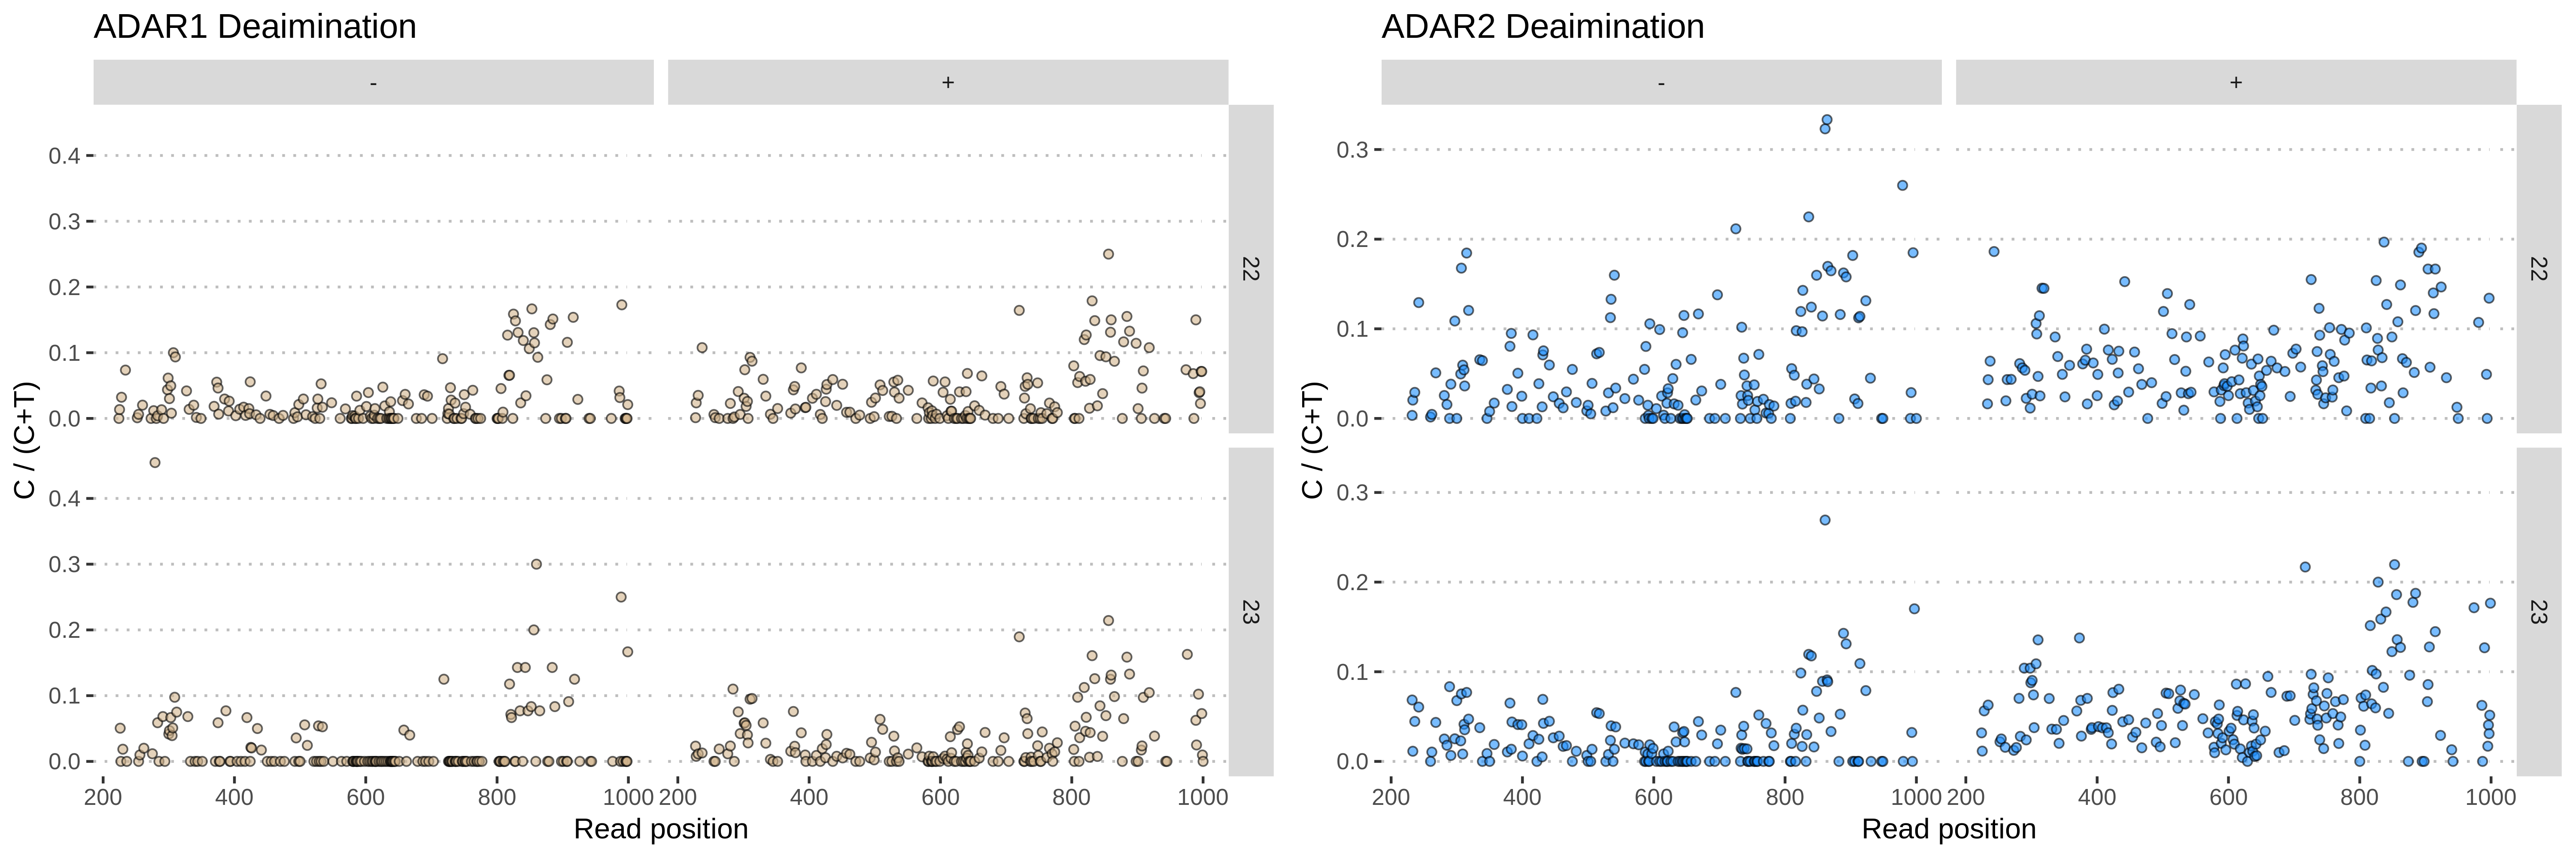

In [21]:
%%R -i all_trace_df_T -w 15 -h 5 --units in -r 400

adar1.df <- subset(all_trace_df_T, ADAR==1)
adar2.df <- subset(all_trace_df_T, ADAR==2)

adar1.plt <- ggplot(adar1.df, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='tan', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) + theme_pubclean() +
        labs(y='C / (C+T)', x='Read position', title='ADAR1 Deaimination')

adar2.plt <- ggplot(adar2.df, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', pch=21, fill='dodgerblue', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) + theme_pubclean() +
        labs(y='C / (C+T)', x='Read position', title='ADAR2 Deaimination')

plt.1 <- ggarrange(adar1.plt, adar2.plt)
ggsave('plots/global_C_to_T_ratio.png', plt.1, dpi=300)
plt.1

## Determine conversion ratios at "CTA" sites which should be the best editing canidates

In [22]:
def identify_cta_sites(df):
    # Determine the row numbers of "T" nucleotides in a reference that are part of a CTA site
    # and only return those rows
    ref_nucs = ''.join(list(df['ref_nuc']))
    finds = re.finditer('CTA', ref_nucs)
    CTA_T_rows = []
    for f in finds:
        CTA_T_rows.append(f.span()[0]+1)
    return df.iloc[CTA_T_rows]

In [23]:
CTA_sites = identify_cta_sites(all_trace_df)

R[write to console]: Saving 15 x 5 in image



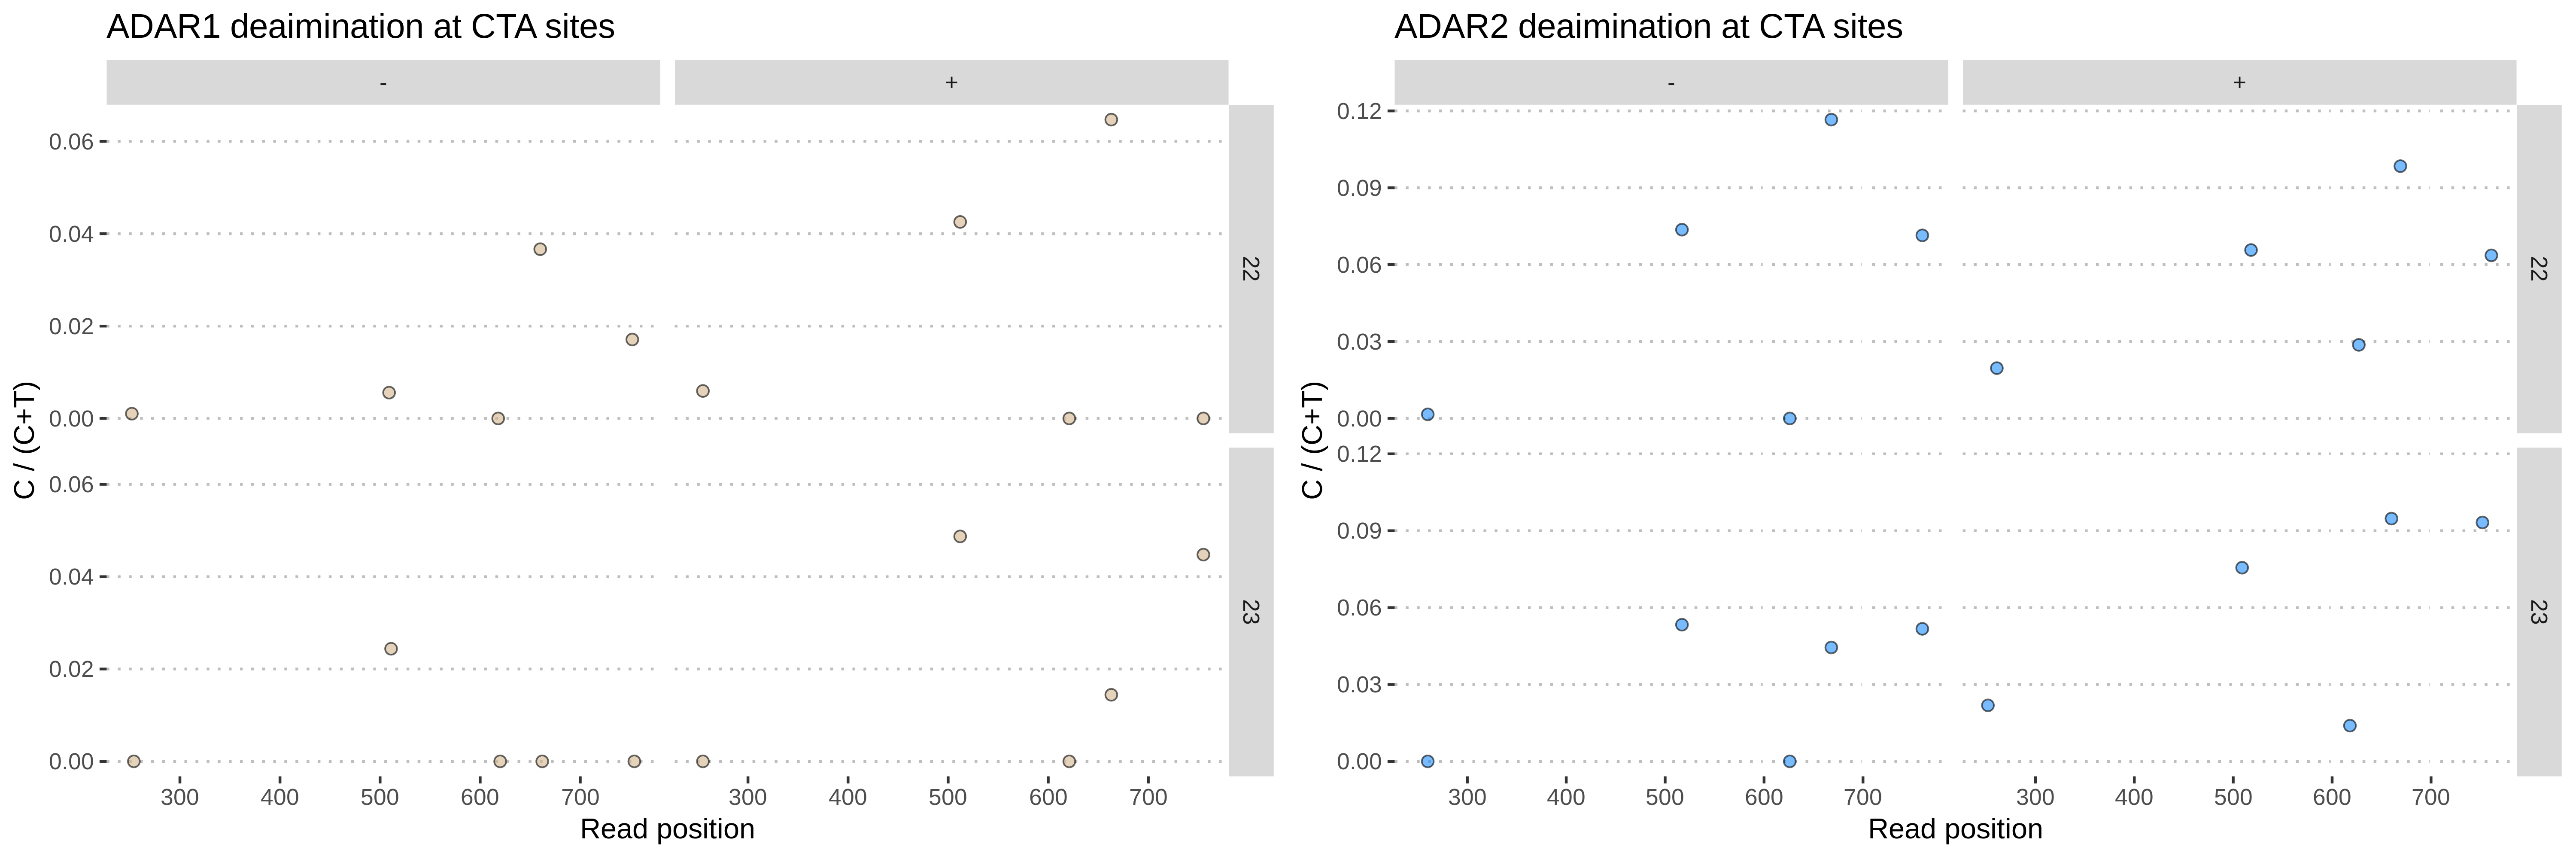

In [24]:
%%R -i CTA_sites -w 15 -h 5 --units in -r 400

adar1.df.cta <- subset(CTA_sites, ADAR==1)
adar2.df.cta <- subset(CTA_sites, ADAR==2)

adar1.plt.cta <- ggplot(adar1.df.cta, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', size=2, pch=21, fill='tan', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) +
        labs(y='C / (C+T)', x='Read position', title='ADAR1 deaimination at CTA sites') + theme_pubclean()

adar2.plt.cta <- ggplot(adar2.df.cta, aes(x=basenum, y=conversion_ratio)) + 
        geom_point(color='black', size=2, pch=21, fill='dodgerblue', alpha=0.6) + 
        facet_grid(row=vars(insert), col=vars(rnaseh)) +
        labs(y='C / (C+T)', x='Read position', title='ADAR2 deaimination at CTA sites') + theme_pubclean()

plt2 <- ggarrange(adar1.plt.cta, adar2.plt.cta)
ggsave('plots/C_to_T_ratio_at_CTA_sites.png', plt2, dpi=300)
plt2